<a href="https://colab.research.google.com/github/raquelcarmo/tropical_cyclones/blob/main/src/code/TC_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# getting in the directory 
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
%ls

/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
best_track/                            SAR_swath_images_VV+VH+VH/
categorisation.png                     SAR_swath_images_VV+VH+WS/
identification.png                     SAR_swath_images_WS+sWSO+cWSO/
model_comparisons_between_datasets/    SAR_swath_images_WS+WS+WS/
model.png                              SAR_swath_masks/
parametric_model/                      SAR_swath_nc/
SAR_IMAGE_DATASET_EYE_CLASSIFICATION@  SAR_swath_Vmax/
SAR_swath_images@


In [ ]:
# general imports
import random
import glob
import os
import sys
sys.stdout.flush()
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import imageio
import os.path
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from google.colab.patches import cv2_imshow
import random
from shapely.geometry import Point
import re
import pickle
import scipy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import concatenate, Dense, GlobalAveragePooling2D

## Comparison between 2 models.

In [ ]:
# COMPARISON BETWEEN TWO MODELS
main_dir = "SAR_swath_images_VV+VH+WS/"
sub_dir = main_dir + "classification_results/categorization/"
# note that the result (in this case the recall) could be null if the classifier is broken (all recall = 1 because is always classified as positive class)
MODEL_1_DIRECTORY = sub_dir + "ResNet_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T_Sq-T/csv"
MODEL_2_DIRECTORY = sub_dir + "ResNet_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/csv"

t value accuracy: 0.4341114580993057
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value precision: 0.59273296347641
Null hypothesis not rejected -> I assume that each difference in precision is due to the randomness
t value recall: -0.23686321051698364
Null hypothesis not rejected -> I assume that each difference in recall is due to the randomness


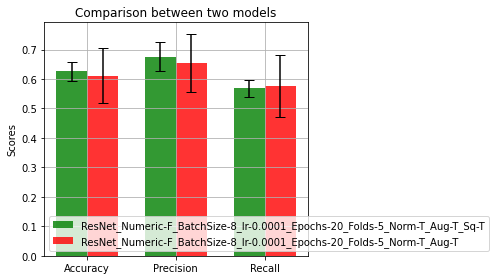

In [ ]:
# Critical t-value to see the difference in two distribution with 5 samples
# 80% confidence
criticalTvalue = 1.533

# 90% confidence
#criticalTvalue = 2.132

# 95% confidence
#criticalTvalue = 2.776


def mean_confidence_interval(data, confidence=0.80):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


# Accuracy analysis
model1_accuracy = pickle.load(open(MODEL_1_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model2_accuracy = pickle.load(open(MODEL_2_DIRECTORY + "/test_accuracy.pkl",  "rb" ))

model1_accuracy_mean, b_model1_acc, u_model1_acc = mean_confidence_interval(model1_accuracy)
model2_accuracy_mean, b_model2_acc, u_model2_acc = mean_confidence_interval(model2_accuracy)

t, p = scipy.stats.ttest_ind(model1_accuracy, model2_accuracy)
print("t value accuracy: {}".format(t))

if t > criticalTvalue or t < -criticalTvalue :
    print("Null hypothesis rejected -> there is a significant difference in the two accuracy distributions")
else:
    print("Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness")


# Precision analysis
model1_precision = pickle.load(open(MODEL_1_DIRECTORY + "/test_precision.pkl",  "rb" ))
model2_precision = pickle.load(open(MODEL_2_DIRECTORY + "/test_precision.pkl",  "rb" ))

model1_precision_mean, b_model1_p, u_model1_p = mean_confidence_interval(model1_precision)
model2_precision_mean, b_model2_p, u_model2_p = mean_confidence_interval(model2_precision)

t, p = scipy.stats.ttest_ind(model1_precision, model2_precision)
print("t value precision: {}".format(t))

if t > criticalTvalue or t < -criticalTvalue :
    print("Null hypothesis rejected -> there is a significant difference in the two precision distributions")
else:
    print("Null hypothesis not rejected -> I assume that each difference in precision is due to the randomness")


# Recall analysis
model1_recall = pickle.load(open(MODEL_1_DIRECTORY + "/test_recall.pkl",  "rb" ))
model2_recall = pickle.load(open(MODEL_2_DIRECTORY + "/test_recall.pkl",  "rb" ))

model1_recall_mean, b_model1_r, u_model1_r = mean_confidence_interval(model1_recall)
model2_recall_mean, b_model2_r, u_model2_r = mean_confidence_interval(model2_recall)

t, p = scipy.stats.ttest_ind(model1_recall, model2_recall)
print("t value recall: {}".format(t))

if t > criticalTvalue or t < -criticalTvalue :
    print("Null hypothesis rejected -> there is a significant difference in the two recall distributions")
else:
    print("Null hypothesis not rejected -> I assume that each difference in recall is due to the randomness")


# compute confidence intervals
confidence_model1 = [u_model1_acc - b_model1_acc, u_model1_p - b_model1_p, u_model1_r - b_model1_r]
confidence_model2 = [u_model2_acc - b_model2_acc, u_model2_p - b_model2_p, u_model2_r - b_model2_r]

# data to plot
n_groups = 3
means_model1 = (model1_accuracy_mean, model1_precision_mean, model1_recall_mean)
means_model2 = (model2_accuracy_mean, model2_precision_mean, model2_recall_mean)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_model1, bar_width,
                 yerr = confidence_model1,
                 capsize = 5,
                 alpha = opacity,
                 color = 'g',
                 label = MODEL_1_DIRECTORY.split(sep='/')[-2])

rects2 = plt.bar(index + bar_width, means_model2, bar_width,
                 yerr = confidence_model2,
                 capsize = 5,
                 alpha = opacity,
                 color = 'r',
                 label = MODEL_2_DIRECTORY.split(sep='/')[-2])

plt.ylabel('Scores')
plt.title('Comparison between two models')
plt.xticks(index + bar_width/2, ('Accuracy', 'Precision', 'Recall'))
plt.legend(loc = 'lower left')
plt.grid(True)
#ax.set_ylim(ymin=0.75)
plt.tight_layout()
plt.show()

dir = sub_dir + "model_comparisons/"
os.makedirs(dir, exist_ok=True)
fig.savefig(dir + MODEL_1_DIRECTORY.split(sep='/')[-2] + "_vs_" + MODEL_2_DIRECTORY.split(sep='/')[-2] + ".jpg", bbox_inches='tight')

In [ ]:
#COMPARE CONFUSION MATRIX
TP_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_tp.pkl",  "rb" ))
FP_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_fp.pkl",  "rb" ))
TN_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_tn.pkl",  "rb" ))
FN_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_fn.pkl",  "rb" ))

TP_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_tp.pkl",  "rb" ))
FP_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_fp.pkl",  "rb" ))
TN_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_tn.pkl",  "rb" ))
FN_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_fn.pkl",  "rb" ))

fold = 0
for tp_1, fp_1, tn_1, fn_1, tp_2, fp_2, tn_2, fn_2 in zip(TP_model1, FP_model1, TN_model1, FN_model1, TP_model2, FP_model2, TN_model2, FN_model2):
  fold += 1

  print("Model 1 confusion matrix")
  fig, ax = plt.subplots()  
  my_confusion_matrix = [[tp_1, fn_1], [fp_1, tn_1]]
  plt.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  plt.ylabel("Not present                 Present")
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title("Present                  Not present")
  #plt.colorbar() 
  ax.text(0, 0, int(tp_1), ha="center", va="center", color="black")
  ax.text(1, 0, int(fn_1), ha="center", va="center", color="black")
  ax.text(0, 1, int(fp_1), ha="center", va="center", color="black")
  ax.text(1, 1, int(tn_1), ha="center", va="center", color="black")
  plt.show()

  fig.savefig(MODEL_1_DIRECTORY + "/confusion_matrix_{}.jpg".format(fold))

  print("Model 2 confusion matrix")
  fig, ax = plt.subplots()  
  my_confusion_matrix = [[tp_2, fn_2], [fp_2, tn_2]]
  plt.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  plt.ylabel("Not present                 Present")
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title("Present                  Not present")
  #plt.colorbar() 
  ax.text(0, 0, int(tp_2), ha="center", va="center", color="black")
  ax.text(1, 0, int(fn_2), ha="center", va="center", color="black")
  ax.text(0, 1, int(fp_2), ha="center", va="center", color="black")
  ax.text(1, 1, int(tn_2), ha="center", va="center", color="black")
  plt.show()

  fig.savefig(MODEL_2_DIRECTORY + "/confusion_matrix_{}.jpg".format(fold))

  """
  print("Fold {}:    Model 1                     Model 2".format(fold))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  my_confusion_matrix = [[tp_1, fn_1], [fp_1, tn_1]]
  ax1.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  ax1.set(ylabel = "Not present                 Present",
          title = "   Present          Not present")
  ax1.set_xticks([])
  ax1.set_yticks([])
  #plt.colorbar() 
  ax1.text(0, 0, int(tp_1), ha="center", va="center", color="black")
  ax1.text(1, 0, int(fn_1), ha="center", va="center", color="black")
  ax1.text(0, 1, int(fp_1), ha="center", va="center", color="black")
  ax1.text(1, 1, int(tn_1), ha="center", va="center", color="black")

  my_confusion_matrix = [[tp_2, fn_2], [fp_2, tn_2]]
  ax2.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  ax2.set(ylabel = "Not present                 Present",
          title = "   Present           Not present")
  ax2.set_xticks([])
  ax2.set_yticks([])
  #plt.colorbar() 
  ax2.text(0, 0, int(tp_2), ha="center", va="center", color="black")
  ax2.text(1, 0, int(fn_2), ha="center", va="center", color="black")
  ax2.text(0, 1, int(fp_2), ha="center", va="center", color="black")
  ax2.text(1, 1, int(tn_2), ha="center", va="center", color="black")
  plt.tight_layout()
  plt.show()
  """

## Comparison between 4 models.

In [ ]:
# COMPARISON BETWEEN FOUR MODELS
MODEL_1_DIRECTORY = "SAR_swath_images_VV+VH+WS/classification_results/identification/Mobile_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T/csv"
MODEL_2_DIRECTORY = "SAR_swath_images_VV+VH+VH/classification_results/identification/Mobile_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T/csv"
MODEL_3_DIRECTORY = "SAR_swath_images_WS+WS+WS/classification_results/identification/Mobile_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T/csv"
MODEL_4_DIRECTORY = "SAR_swath_images_WS+sWSO+cWSO/classification_results/identification/Mobile_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T/csv"

t value accuracy: 0.9267467715133052
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value precision: 0.9999999999999994
Null hypothesis not rejected -> I assume that each difference in precision is due to the randomness
t value recall: 0.6057917261668793
Null hypothesis not rejected -> I assume that each difference in recall is due to the randomness


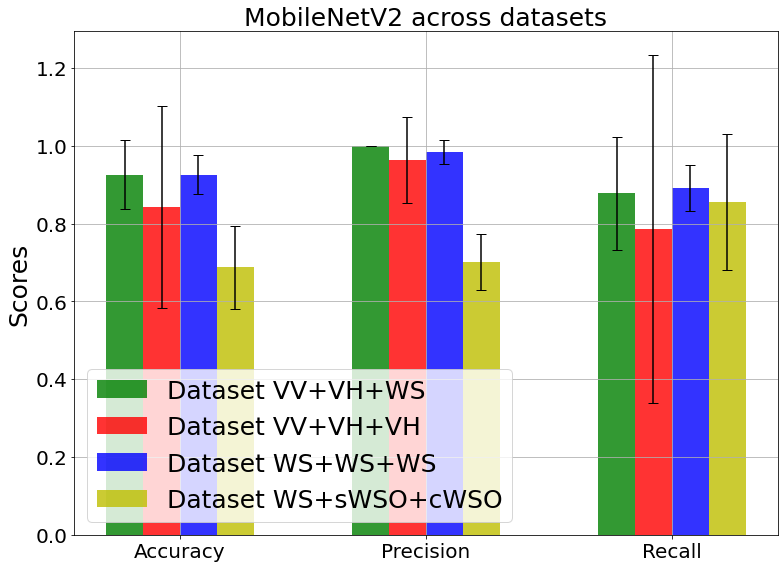

In [ ]:
# Critical t-value to see the difference in two distribution with 5 samples
# 80% confidence
criticalTvalue = 1.533

# 90% confidence
#criticalTvalue = 2.132

# 95% confidence
#criticalTvalue = 2.776


def mean_confidence_interval(data, confidence=0.80):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


# Accuracy analysis
model1_accuracy = pickle.load(open(MODEL_1_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model2_accuracy = pickle.load(open(MODEL_2_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model3_accuracy = pickle.load(open(MODEL_3_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model4_accuracy = pickle.load(open(MODEL_4_DIRECTORY + "/test_accuracy.pkl",  "rb" ))

model1_accuracy_mean, b_model1_acc, u_model1_acc = mean_confidence_interval(model1_accuracy)
model2_accuracy_mean, b_model2_acc, u_model2_acc = mean_confidence_interval(model2_accuracy)
model3_accuracy_mean, b_model3_acc, u_model3_acc = mean_confidence_interval(model3_accuracy)
model4_accuracy_mean, b_model4_acc, u_model4_acc = mean_confidence_interval(model4_accuracy)

t, p = scipy.stats.ttest_ind(model1_accuracy, model2_accuracy)
print("t value accuracy: {}".format(t))
if t > criticalTvalue or t < -criticalTvalue :
    print("Null hypothesis rejected -> there is a significant difference in the two accuracy distributions")
else:
    print("Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness")


# Precision analysis
model1_precision = pickle.load(open(MODEL_1_DIRECTORY + "/test_precision.pkl",  "rb" ))
model2_precision = pickle.load(open(MODEL_2_DIRECTORY + "/test_precision.pkl",  "rb" ))
model3_precision = pickle.load(open(MODEL_3_DIRECTORY + "/test_precision.pkl",  "rb" ))
model4_precision = pickle.load(open(MODEL_4_DIRECTORY + "/test_precision.pkl",  "rb" ))

model1_precision_mean, b_model1_p, u_model1_p = mean_confidence_interval(model1_precision)
model2_precision_mean, b_model2_p, u_model2_p = mean_confidence_interval(model2_precision)
model3_precision_mean, b_model3_p, u_model3_p = mean_confidence_interval(model3_precision)
model4_precision_mean, b_model4_p, u_model4_p = mean_confidence_interval(model4_precision)

t, p = scipy.stats.ttest_ind(model1_precision, model2_precision)
print("t value precision: {}".format(t))
if t > criticalTvalue or t < -criticalTvalue :
    print("Null hypothesis rejected -> there is a significant difference in the two precision distributions")
else:
    print("Null hypothesis not rejected -> I assume that each difference in precision is due to the randomness")


# Recall analysis
model1_recall = pickle.load(open(MODEL_1_DIRECTORY + "/test_recall.pkl",  "rb" ))
model2_recall = pickle.load(open(MODEL_2_DIRECTORY + "/test_recall.pkl",  "rb" ))
model3_recall = pickle.load(open(MODEL_3_DIRECTORY + "/test_recall.pkl",  "rb" ))
model4_recall = pickle.load(open(MODEL_4_DIRECTORY + "/test_recall.pkl",  "rb" ))

model1_recall_mean, b_model1_r, u_model1_r = mean_confidence_interval(model1_recall)
model2_recall_mean, b_model2_r, u_model2_r = mean_confidence_interval(model2_recall)
model3_recall_mean, b_model3_r, u_model3_r = mean_confidence_interval(model3_recall)
model4_recall_mean, b_model4_r, u_model4_r = mean_confidence_interval(model4_recall)

t, p = scipy.stats.ttest_ind(model1_recall, model2_recall)
print("t value recall: {}".format(t))
if t > criticalTvalue or t < -criticalTvalue :
    print("Null hypothesis rejected -> there is a significant difference in the two recall distributions")
else:
    print("Null hypothesis not rejected -> I assume that each difference in recall is due to the randomness")


# compute confidence intervals
confidence_model1 = [u_model1_acc - b_model1_acc, u_model1_p - b_model1_p, u_model1_r - b_model1_r]
confidence_model2 = [u_model2_acc - b_model2_acc, u_model2_p - b_model2_p, u_model2_r - b_model2_r]
confidence_model3 = [u_model3_acc - b_model3_acc, u_model3_p - b_model3_p, u_model3_r - b_model3_r]
confidence_model4 = [u_model4_acc - b_model4_acc, u_model4_p - b_model4_p, u_model4_r - b_model4_r]

# data to plot
n_groups = 3
means_model1 = (model1_accuracy_mean, model1_precision_mean, model1_recall_mean)
means_model2 = (model2_accuracy_mean, model2_precision_mean, model2_recall_mean)
means_model3 = (model3_accuracy_mean, model3_precision_mean, model3_recall_mean)
means_model4 = (model4_accuracy_mean, model4_precision_mean, model4_recall_mean)

# create plot
fig, ax = plt.subplots(figsize=(11,8))
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, means_model1, bar_width,
                 yerr = confidence_model1,
                 capsize = 5,
                 alpha = opacity,
                 color = 'g',
                 #label = MODEL_1_DIRECTORY.split(sep='/')[0]
                 label = "Dataset VV+VH+WS")

rects2 = plt.bar(index + bar_width, means_model2, bar_width,
                 yerr = confidence_model2,
                 capsize = 5,
                 alpha = opacity,
                 color = 'r',
                 #label = MODEL_2_DIRECTORY.split(sep='/')[0]
                 label = "Dataset VV+VH+VH")

rects3 = plt.bar(index + 2 * bar_width, means_model3, bar_width,
                 yerr = confidence_model3,
                 capsize = 5,
                 alpha = opacity,
                 color = 'b',
                 #label = MODEL_3_DIRECTORY.split(sep='/')[0]
                 label = "Dataset WS+WS+WS")

rects4 = plt.bar(index + 3 * bar_width, means_model4, bar_width,
                 yerr = confidence_model4,
                 capsize = 5,
                 alpha = opacity,
                 color = 'y',
                 #label = MODEL_4_DIRECTORY.split(sep='/')[0]
                 label = "Dataset WS+sWSO+cWSO")

font_size = 25
font_size_ticks = 20
plt.ylabel('Scores', fontsize = font_size)
#plt.title(MODEL_1_DIRECTORY.split(sep='/')[-2])
plt.title("MobileNetV2 across datasets", fontsize = font_size)
plt.xticks(index + 1.5*bar_width, ('Accuracy', 'Precision', 'Recall'), fontsize = font_size_ticks)
plt.yticks(fontsize = font_size_ticks)
plt.legend(loc = 'lower left', prop={'size': font_size})
plt.grid(True)
#ax.set_ylim(ymin=0.75)
plt.tight_layout()
plt.show()

dir = "model_comparisons_between_datasets/identification/"
os.makedirs(dir, exist_ok=True)
#fig.savefig(dir + "{}_across_datasets.jpg".format(MODEL_1_DIRECTORY.split(sep='/')[-2]), bbox_inches='tight')
fig.savefig(dir + "MobileNetV2 across datasets_2.jpg", bbox_inches='tight')